In [1]:
from pathlib import Path
import statistics

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_path = Path().resolve().parent / 'imgs' / 'middle.JPG'
img_path.is_file()

True

In [3]:
def img_import(file_path: str) -> tuple:
    #OpenCV uses BGR not RGB
    img = cv.imread(str(img_path), 1)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return (img, img_gray)
    
def img_show(img: np.ndarray) -> None:
    plt.figure(figsize=(20,10))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img[...,::-1])

def get_contours(img: np.ndarray) -> np.ndarray:
    if len(img.shape) > 2:
        raise ValueError('Length of img.shape is greater than 2.\nImage must be a 2D numpy.ndarray.\nTry converting to grayscale?')
    
    ret, thresh = cv.threshold(img, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

def get_photo_contour(contours: tuple, hierarchy: np.ndarray) -> np.ndarray:
    photos = []
    for idx, val in enumerate(hierarchy[0]):
        _next, _prev, _child, _parent = val
        if _next == -1 and _parent == 0 and _child != -1:
            photos.append(contours[idx])
            
    # TODO - Add code to handle if there are multiple photos in a single img/scan
    if len(photos) > 1:
        print('photos length is greater than 1.... possibly more than one photo? multiple photos code not implimented yet')
        return
    else:
        return photos

def deskew(img: np.ndarray, photo_contour: np.ndarray) -> np.ndarray:
    rect = cv.minAreaRect(photo_contour[0])
    angle = rect[-1]
    h, w = img.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, angle-360, 1.0)
    deskewed = cv.warpAffine(img, M, (h, w))
    return deskewed
    
def get_photo_boundies(photo_contour: np.ndarray):
    rect = cv.minAreaRect(photo_contour[0])
    print(rect)
    print(type(rect))
    angle = rect[-1]
    box = np.int0(cv.boxPoints(rect))
    return box

def crop_rect(img: np.ndarray, rect: tuple) -> np.ndarray:
    center, size, angle = rect
    print(angle)
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # height, width = img.shape[:2]
    height, width = (img.shape[1], img.shape[0])  
    
    if width < height:
        angle -= 90
        width, height = height, width
      
    M = cv.getRotationMatrix2D(center, angle, 1)
    img_rot = cv.warpAffine(img, M, (width, height))
    img = cv.getRectSubPix(img_rot, size, center)

    # return img_crop, img_rot
    x = int(center[0] - width // 2)
    y = int(center[1] - height // 2)
    
    print(f'{x}:{x + height}, {y}:{y + width}')

    img = img[y : y + height, x : x + width]
    return img, img_rot

def add_border(img: np.ndarray) -> np.ndarray:
    row, col = img.shape[:2]
    bottom = img[row-2:row, 0:col]
    mean = cv.mean(bottom)[0]

    bordersize = 500
    border = cv.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv.BORDER_CONSTANT,
        value=[mean, mean, mean]
    )
    return border

In [4]:
img, img_gray = img_import(img_path)
with_border = add_border(img)
# img_gray = cv.cvtColor(with_border, cv.COLOR_BGR2GRAY)
contours, hierarchy = get_contours(img_gray)
photo = get_photo_contour(contours, hierarchy)
rect = cv.minAreaRect(photo[0])
img_crop, img_rot = crop_rect(img, rect)

89.260986328125
-730:1750, -100:3131


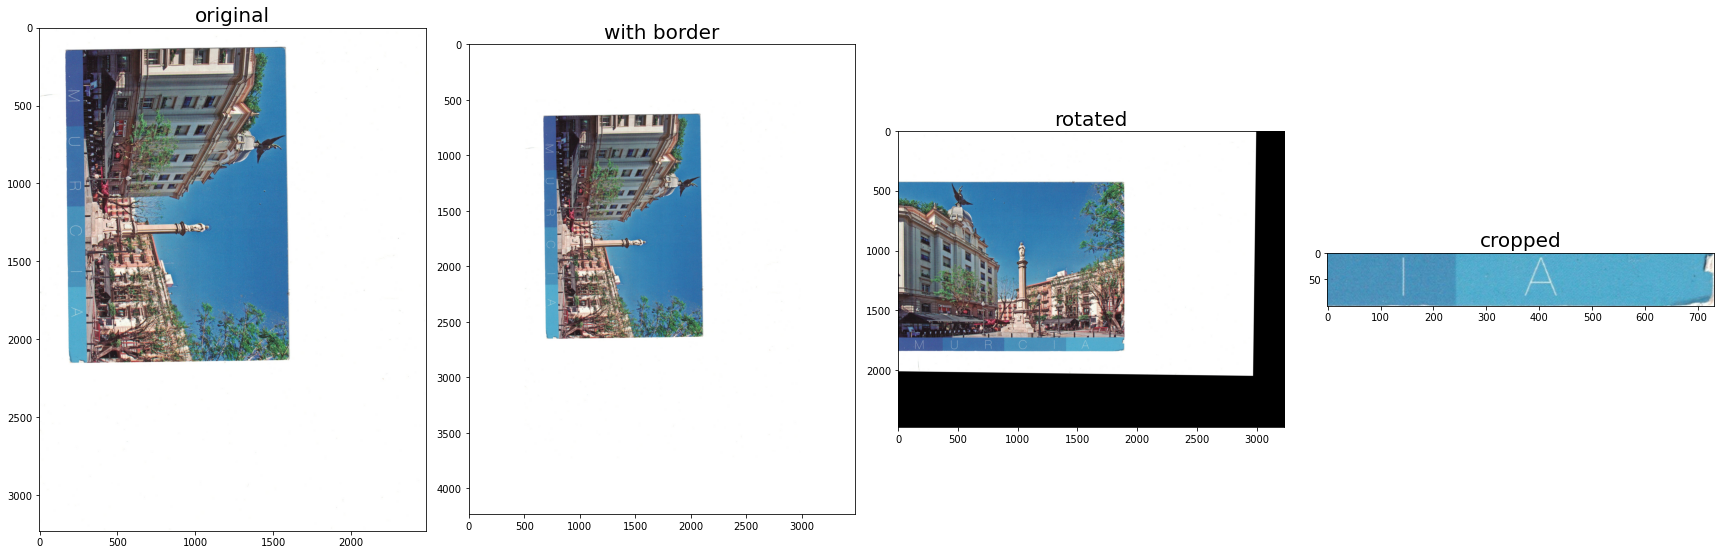

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 12))

ax[0].imshow(img[...,::-1])
ax[0].set_title('original', fontsize=20)

ax[1].imshow(with_border[...,::-1])
ax[1].set_title('with border', fontsize=20)

ax[2].imshow(img_rot[...,::-1])
ax[2].set_title('rotated', fontsize=20)

ax[3].imshow(img_crop[...,::-1])
ax[3].set_title('cropped', fontsize=20)

fig.tight_layout()